In [1]:
import bagpy
from tqdm import tqdm
from typing import *
from shapely.geometry import *
from os.path import join, exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import geopandas as gpd

In [2]:
worlds_df = pd.read_pickle("/home/agusmazzeo/Documents/UTN/Proyecto/worlds_df.pkl")

In [3]:
worlds_df

,world,world_dir,starting_point,free_area,finished_false,finished_true
evaluation_7,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_7.world,"(44.3730343170481, 45.43376604621937)",1586.841949,True,True
evaluation_1,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_1.world,"(38.13039752687315, 44.08558532764939)",1207.029552,True,True
evaluation_5,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_5.world,"(30.162369766644044, 17.229534857934745)",1470.062424,True,True
evaluation_0,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_0.world,"(47.59203620653866, 21.969882899768308)",1093.128472,True,True
evaluation_9,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_9.world,"(27.146833573506807, 26.35109100999387)",1227.752651,True,True
...,...,...,...,...,...,...
evaluation_194,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_194.world,"(22.244891259682838, 5.356341056526373)",891.868292,False,False
evaluation_195,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_195.world,"(41.545717721344076, 10.354559752761045)",712.452498,False,False
evaluation_196,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_196.world,"(11.235190104396708, 7.134928722218135)",1313.795085,False,False
evaluation_197,<FrontierExploration.preprocessing.layout.synt...,/home/ramiro/.gazeboworlds/evaluation_197.world,"(49.83808475194827, 15.364919697504677)",1454.669774,False,False


In [48]:
class BagpyDataHandler:
    
    def __init__(self, worlds_df: pd.DataFrame, outputs_dir: str):
        self.res_values = {}
        self.report = {}
        self.worlds = {}
        for index in tqdm(worlds_df[worlds_df["finished_true"]].index):
            try:
                result = self.get_results_from_folder(join(outputs_dir, index))
                if result is not None:
                    self.res_values[index] = result
                    self.worlds[index] = worlds_df.loc[index]
                    self.report[index] = self.get_report_data(index, result)
            except Exception:
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in self.report.items() for innerKey, values in innerDict.items()}
        self.report_df = pd.DataFrame(reform)
                
    def get_report_data(self, index: str, result: Dict[str, Any]):
        report = {}
        world_polygon = self.worlds[index].world.free_space_polygon
        if isinstance(world_polygon, MultiPolygon):
            world_polygon = world_polygon.convex_hull
        for key in result.keys():
            if key not in report.keys():
                report[key] = {}
            poly = gpd.GeoDataFrame(geometry=[world_polygon.exterior])
            report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
        return report
    
    def get_exploration_data(self, key: str, index: str, result: Dict[str, Any]):
        free_area = self.worlds[index]["free_area"]
        explored_per_distance = pd.merge_asof(result[key]["explored_df"], result[key]["travelled_distance_df"], on="timestamp")
        explored_area = explored_per_distance["m_2_explored"].iloc[-1]
        exploration = {
            "explored_percentage": 100*explored_area/free_area,
            "total_time_sec": explored_per_distance.index[-1],
            "dist_explored_20%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(20*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_50%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(50*free_area/100)].iloc[-1]["cum_distance"],
            "dist_explored_80%": explored_per_distance.loc[explored_per_distance["m_2_explored"]<(80*free_area/100)].iloc[-1]["cum_distance"],
            "dist_total": explored_per_distance.iloc[-1]["cum_distance"],
        }
        return exploration
            
    def get_results_from_folder(self, folder: str) -> Dict[str, Tuple[List[float], List[float]]]:
        try:
            utn_path = join(folder, "UTN")
            maryland_path = join(folder, "MARYLAND")
            if not exists(utn_path) or not exists(maryland_path):
                # print(f"Skipping {folder} because of not having both maryland and UTN")
                return None
            utn_bag_file = glob(join(utn_path, "*.bag"))[0]
            maryland_bag_file = glob(join(maryland_path, "*.bag"))[0]
            reader_utn = bagpy.bagreader(utn_bag_file)
            reader_maryland = bagpy.bagreader(maryland_bag_file)
            res = {"UTN": self.get_times_and_explores(reader_utn), "MARYLAND": self.get_times_and_explores(reader_maryland)}
            return res
        except Exception as ex:
            print(f"An error ocurred on {folder}: {ex}")
            return None
    
    @staticmethod
    def get_explored_df(reader: bagpy.bagreader) -> pd.DataFrame:
        explored_data =  reader.reader.read_messages("/create1/explored")
        amt_of_non_unknown = []
        timestamps = []
        for d in explored_data:
            amt_of_non_unknown.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        amt_of_non_unknown = [0.0025 * item for item in amt_of_non_unknown]
        dic = {"timestamp": timestamps, "m_2_explored": amt_of_non_unknown}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_travelled_distance_df(reader: bagpy.bagreader) -> pd.DataFrame:
        travelled_data =  reader.reader.read_messages("/create1/travelled_distance")
        cum_distance = []
        timestamps = []
        for d in travelled_data:
            cum_distance.append(d.message.data)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "cum_distance": cum_distance}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return df

    @staticmethod
    def get_trajectory_df(reader: bagpy.bagreader) -> gpd.GeoDataFrame:
        gts =  reader.reader.read_messages("/create1/gts")
        xs = []
        ys = []
        timestamps = []
        for d in gts:
            xs.append(d.message.pose.pose.position.x)
            ys.append(d.message.pose.pose.position.y)
            timestamps.append(d.timestamp.to_sec())
        dic = {"timestamp": timestamps, "x": xs, "y": ys}
        df = pd.DataFrame(dic)
        df["timestamp"] -= dic["timestamp"][0]
        df = df.set_index("timestamp")
        return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    def get_times_and_explores(self, reader: bagpy.bagreader) -> Tuple[List[float], List[float]]:
        explored_df = self.get_explored_df(reader)
        travelled_distance_df = self.get_travelled_distance_df(reader)
        trajectory_df = self.get_trajectory_df(reader)
        return {"explored_df": explored_df, "travelled_distance_df":travelled_distance_df, "trajectory_df":trajectory_df}

    def plot_exp_by_dist(self, index: str):
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["timestamp"], utn_df["m_2_explored"], label="UTN")
        plt.plot( maryland_df["timestamp"], maryland_df["m_2_explored"], label="MARYLAND")
        plt.ylabel("Explored area [m2]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
        
    def plot_exp_percentage_by_dist(self, index: str):
        total_area = self.worlds[index].loc['world'].total_area
        res = self.res_values[index]
        utn_df=  pd.merge_asof(res["UTN"]["explored_df"], res["UTN"]["travelled_distance_df"], on="timestamp")
        maryland_df=  pd.merge_asof(res["MARYLAND"]["explored_df"], res["MARYLAND"]["travelled_distance_df"], on="timestamp")
        utn_df = utn_df.dropna()
        maryland_df = maryland_df.dropna()

        plt.plot( utn_df["cum_distance"], 100*utn_df["m_2_explored"]/total_area, label="UTN")
        plt.plot( maryland_df["cum_distance"], 100*maryland_df["m_2_explored"]/total_area, label="MARYLAND")
        plt.ylabel("Explored area [%]")
        plt.xlabel("Distance travelled [m]")

        plt.legend()
    
    def plot_trajectory(self, index: str):
        report = self.report[index]
        report["UTN"]["trajectory"].buffer(0.2).plot()
        report["MARYLAND"]["trajectory"].buffer(0.2).plot()
        

In [43]:
BASE_DIR = "/home/agusmazzeo/Documents/UTN/Proyecto/outputs"

In [44]:
bdh = BagpyDataHandler(worlds_df, BASE_DIR) 

  0%|                                                                                                                                                                                                                                             | 0/77 [00:00<?, ?it/s]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_1/UTN/exploration_data_2022-10-26-12-47-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_1/MARYLAND/exploration_data_2022-10-26-12-47-02 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  3%|█████▉                                                                                                                                                                                                                               | 2/77 [00:01<01:06,  1.13it/s]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_5/UTN/exploration_data_2022-10-26-12-47-03 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_5/MARYLAND/exploration_data_2022-10-26-12-47-03 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  4%|████████▉                                                                                                                                                                                                                            | 3/77 [00:06<02:52,  2.33s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_0/UTN/exploration_data_2022-10-26-13-13-06.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_0/MARYLAND/exploration_data_2022-10-26-13-07-41.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  5%|███████████▉                                                                                                                                                                                                                         | 4/77 [00:08<02:42,  2.23s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_9/UTN/exploration_data_2022-10-26-13-31-21.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_9/MARYLAND/exploration_data_2022-10-26-13-14-26.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  6%|██████████████▊                                                                                                                                                                                                                      | 5/77 [00:09<02:27,  2.05s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_6/UTN/exploration_data_2022-10-26-13-46-33 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_6/MARYLAND/exploration_data_2022-10-26-13-31-39.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  8%|█████████████████▊                                                                                                                                                                                                                   | 6/77 [00:12<02:34,  2.17s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_3/UTN/exploration_data_2022-10-26-13-59-18.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_3/MARYLAND/exploration_data_2022-10-26-13-47-11.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
  9%|████████████████████▊                                                                                                                                                                                                                | 7/77 [00:14<02:41,  2.31s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_2: list index out of range
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_8/UTN/exploration_data_2022-10-26-14-27-24 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_8/MARYLAND/exploration_data_2022-10-26-14-26-27 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 12%|██████████████████████████▊                                                                                                                                                                                                          | 9/77 [00:16<01:42,  1.50s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_10/UTN/exploration_data_2022-10-26-14-46-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_10/MARYLAND/exploration_data_2022-10-26-14-38-17 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 13%|█████████████████████████████▌                                                                                                                                                                                                      | 10/77 [00:19<02:06,  1.89s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_12/UTN/exploration_data_2022-10-26-15-10-29.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_12/MARYLAND/exploration_data_2022-10-26-14-50-01 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 14%|████████████████████████████████▌                                                                                                                                                                                                   | 11/77 [00:22<02:32,  2.30s/it]/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_19/UTN/exploration_data_2022-10-26-15-13-20 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_19/MARYLAND/exploration_data_2022-10-26-15-11-43 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_16/UTN/exploration_data_2022-10-26-15-17-22 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_16/MARYLAND/exploration_data_2022-10-26-15-15-01 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 17%|██████████████████████████████████████▍                                                                                                                                                                                             | 13/77 [00:25<02:00,  1.89s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_11/UTN/exploration_data_2022-10-26-15-42-37.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_11/MARYLAND/exploration_data_2022-10-26-15-38-14 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 18%|█████████████████████████████████████████▍                                                                                                                                                                                          | 14/77 [00:27<02:01,  1.93s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_14/UTN/exploration_data_2022-10-26-15-52-20 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_14/MARYLAND/exploration_data_2022-10-26-15-44-24 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 19%|████████████████████████████████████████████▍                                                                                                                                                                                       | 15/77 [00:29<02:03,  1.99s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_18/UTN/exploration_data_2022-10-26-16-07-38.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_18/MARYLAND/exploration_data_2022-10-26-16-01-14.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 21%|███████████████████████████████████████████████▍                                                                                                                                                                                    | 16/77 [00:32<02:20,  2.30s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_17/UTN/exploration_data_2022-10-26-16-28-15 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_17/MARYLAND/exploration_data_2022-10-26-16-15-36 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 22%|██████████████████████████████████████████████████▎                                                                                                                                                                                 | 17/77 [00:34<02:19,  2.32s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_21/UTN/exploration_data_2022-10-26-16-38-05 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_21/MARYLAND/exploration_data_2022-10-26-16-32-28 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 23%|█████████████████████████████████████████████████████▎                                                                                                                                                                              | 18/77 [00:37<02:26,  2.48s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_23/UTN/exploration_data_2022-10-26-17-00-03.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_23/MARYLAND/exploration_data_2022-10-26-16-58-02.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                           | 19/77 [00:43<03:19,  3.45s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_25/UTN/exploration_data_2022-10-26-17-12-44.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_25/MARYLAND/exploration_data_2022-10-26-17-05-34 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 26%|███████████████████████████████████████████████████████████▏                                                                                                                                                                        | 20/77 [00:52<04:57,  5.22s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_22/UTN/exploration_data_2022-10-26-17-54-35 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_22/MARYLAND/exploration_data_2022-10-26-17-32-37.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 27%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 21/77 [00:56<04:26,  4.75s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_27/UTN/exploration_data_2022-10-26-18-05-50.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_27/MARYLAND/exploration_data_2022-10-26-18-00-15 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 22/77 [01:02<04:36,  5.03s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_26/UTN/exploration_data_2022-10-26-18-24-46 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_26/MARYLAND/exploration_data_2022-10-26-18-13-00.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 30%|████████████████████████████████████████████████████████████████████                                                                                                                                                                | 23/77 [01:05<03:59,  4.44s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_29/UTN/exploration_data_2022-10-26-18-32-08.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_29/MARYLAND/exploration_data_2022-10-26-18-29-21.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 31%|███████████████████████████████████████████████████████████████████████                                                                                                                                                             | 24/77 [01:09<03:49,  4.33s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_32/UTN/exploration_data_2022-10-26-18-58-41.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_32/MARYLAND/exploration_data_2022-10-26-18-54-05 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 32%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 25/77 [01:12<03:33,  4.10s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_31/UTN/exploration_data_2022-10-26-19-09-11.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_31/MARYLAND/exploration_data_2022-10-26-19-06-02.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 34%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 26/77 [01:21<04:42,  5.55s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_30/UTN/exploration_data_2022-10-26-19-31-26.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_30/MARYLAND/exploration_data_2022-10-26-19-14-50.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 35%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 27/77 [01:26<04:26,  5.34s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_35/UTN/exploration_data_2022-10-26-19-58-29 already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_35/MARYLAND/exploration_data_2022-10-26-19-36-38.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 36%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 28/77 [01:32<04:27,  5.47s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_34/UTN/exploration_data_2022-10-26-20-09-22.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_34/MARYLAND/exploration_data_2022-10-26-20-06-14.orig already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 38%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 29/77 [01:35<03:53,  4.87s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_33/UTN/exploration_data_2022-10-26-20-34-47.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_33/MARYLAND/exploration_data_2022-10-26-20-10-11 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
 39%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 30/77 [01:39<03:29,  4.45s/it]

[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_39/UTN/exploration_data_2022-10-26-20-42-48.orig already exists. Not creating.
[INFO]  Data folder /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_39/MARYLAND/exploration_data_2022-10-26-20-35-53 already exists. Not creating.


/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
/tmp/ipykernel_7979/4216487502.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report[key] = {"trajectory": poly.append(result[key]["trajectory_df"]), **self.get_exploration_data(key, index, result)}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:41<00:00,  1.32s/it]

An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_36: list index out of range
An error ocurred on /home/agusmazzeo/Documents/UTN/Proyecto/outputs/evaluation_44: list index out of range


In [46]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in bdh.report.items() for innerKey, values in innerDict.items()}
data_check = pd.DataFrame(reform).T

## Ideas KPI

- Graficar diferencia de distancia en funcion del area total de cada corrida
- Casos de exito frente al total de corridas (numero en porcentaje)

In [51]:
data_check

trajectory  \
evaluation_1  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_5  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_0  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_9  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_6  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_3  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_8  UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_10 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_12 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_16 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_11 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_14 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_18 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_17 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_21 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_23 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_25 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_22 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_27 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_29 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_32 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_31 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_30 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_35 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_34 UTN                                                     ...   
              MARYLAND                                                ...   
evaluation_33 UTN                                                     ...   
              MARYLAND                                     

In [100]:
dist_diff = {}
for evaluation in data_check.index:
    data = data_check.loc[evaluation[0]]
    total_area = bdh.worlds[evaluation[0]]['free_area']
    dist_diff[evaluation[0]] = {
        'diff': int(data.loc['MARYLAND']['dist_total']-data.loc['UTN']['dist_total']),
        'total_area': total_area
    }
dist_diff_df = pd.DataFrame(dist_diff).T.sort_values('total_area')

In [107]:
dist_diff_df.drop('evaluation_27', inplace=True)

<AxesSubplot:xlabel='total_area'>

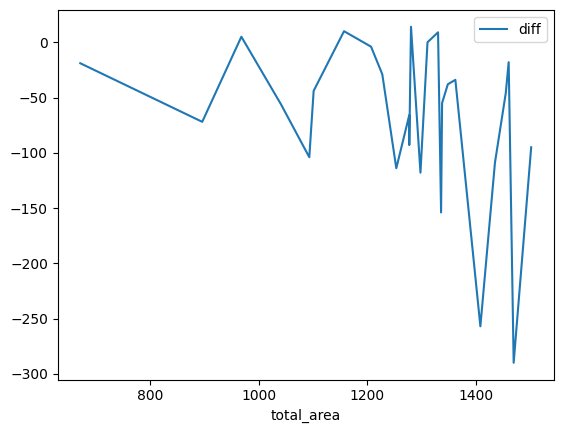

In [108]:
dist_diff_df.plot(x='total_area', y='diff')

In [84]:
dist_diff_df.shape[0]

27

In [85]:
100*dist_diff_df[dist_diff_df['diff']>0].shape[0]/dist_diff_df.shape[0]

18.51851851851852

In [83]:
100*dist_diff_df[dist_diff_df['diff']<0].shape[0]/dist_diff_df.shape[0]

77.77777777777777